In [13]:
import numpy as np
import cvxpy as cp
import scipy as sp
import torch
from datetime import datetime
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from warnings import filterwarnings
filterwarnings('ignore', category=np.ComplexWarning)

## Simulation Parameters

In [14]:
dt = torch.Tensor([0.04])  # timestep
t = torch.Tensor([1])  # duration
m = torch.Tensor([1])  # mass
q0 = torch.Tensor([0, 0])  # init pos
v0 = torch.Tensor([5, 2])  # init vel
v0.requires_grad = True
force = torch.Tensor([0, 30])  # init force
g = torch.Tensor([9.8])  # gravitational acceleration
mu = torch.Tensor([0.05])  # coefficient of friction of the plane

## Simulation Backend

In [15]:
class SimSystem:
    def __init__(self, q0, v0):
        self.q = q0
        self.v = v0
    
    def step_q(self, update=True):
        """ Find next q according to system dynamics. Store if UPDATE. """
        raise NotImplementedError()
        
    def step_v(self, update=True):
        """ Find next v according to system dynamics. Store if UPDATE. """
        raise NotImplementedError()
    
    def plot(self, q=None):
        """
        Generate a plot for current config (or for Q if specified)
        """
        raise NotImplementedError()
    
    @property
    def dim(self):
        return self.q.shape[0]
        

In [28]:
class Block2DFriction(SimSystem):
    def __init__(self, pos, vel, mass, force,
                 dt=dt, mu=mu, solver='eig0'):
        super().__init__(pos, vel)
        self.m = mass
        self.f = force
        self.dt = dt
        self.mu = mu
        self.solver = solver
    
    def step_q(self, update=True):
        q_new = self.q + self.dt * self.v
        if update:
            self.q = q_new
        return q_new
    
    def step_v(self, update=True):
        self.b = self.get_b_eig()
        v_new = self.v + (self.b + self.dt * self.f) / self.m  # self.v + self.m.inv @ (self.b - self.dt * self.f)
        if update:
            self.v = v_new
        return v_new
    
#     def get_b(self):
#         """
#         b = argmin(v^\top v) s.t. b^\top b <= (\mu * m * g)^2. set to self.b for debugging purposes.
#         """
#         if self.solver in ['eig0', 'eig1']:
#             self.b = self.get_b_eig()
#         else:
#             b = cp.Variable(self.dim)
#             constraints = [cp.SOC(self.mu * self.m * g, b)]
#             z = b + self.dt * self.f
#             prob = cp.Problem(cp.Minimize(cp.norm(z, 2)**2 + 2 * self.m * (z @ self.v)),
#                               constraints)
#             prob.solve(solver=self.solver)
#             self.b = b.value
#         return self.b
    
    def get_b_eig(self):
        alpha = 1  # "an arbitrary alpha > 0 (p. 10)"
        """ Interior case """
        b0 = -self.f * self.dt - self.m * self.v
        delta = self.mu * self.m * g
        """ Boundary case """
        # set up generalized eigenvalue problem
        expr = (self.f * self.dt + self.m * self.v).reshape(self.dim, 1)
        if self.solver == 'eig0':
            A = -torch.cat((
                torch.cat(((delta**2)[None], torch.zeros(self.dim, 1), expr)).T,
                torch.cat((torch.zeros(1, self.dim), -torch.eye(self.dim), torch.eye(self.dim))).T,
                torch.cat((expr.T, torch.eye(self.dim), torch.zeros(self.dim, self.dim))).T
            )).float()
            B = -torch.cat((
                torch.zeros(1, 1 + 2*self.dim),
                torch.cat((torch.zeros(1 + self.dim, self.dim), -torch.eye(self.dim))).T,
                torch.cat((torch.zeros(1, self.dim), -torch.eye(self.dim), torch.zeros(self.dim, self.dim))).T
            )).float()
            split_sizes = [1, 2, 2]
            sorted_largest_eig_idx = -2  # skip inf eigval
        elif self.solver == 'eig1':
            A = torch.cat((
                torch.cat((torch.eye(self.dim), -torch.eye(self.dim))).T,
                torch.cat((-torch.eye(self.dim), (expr @ expr.T) / (delta**2))).T,
            )).float()
            B = torch.cat((
                torch.cat((torch.zeros(self.dim, self.dim), torch.eye(self.dim))).T,
                torch.cat((torch.eye(self.dim), torch.zeros(self.dim, self.dim))).T
            )).float()
            split_sizes = [0, 2, 2]
            sorted_largest_eig_idx = -1  # only finite eigvals
        else:
            raise ValueError('This function is for solvers eig0 or eig1, specifying the matrix pencil used.')
        # solve the generalized eigenvalue problem w/o autograd
        with torch.no_grad():
            A_np, B_np = A.detach().numpy().astype(np.float32), B.detach().numpy().astype(np.float32)
            eigvals_np, V_np = sp.linalg.eig(A, B)
            eigvals_np = eigvals_np.astype(np.float32)
            V_np = V_np.astype(np.float32)
            eigstacks = [torch.Tensor(np.hstack((V_np[:,i], eigvals_np[i]))) for i in range(len(eigvals_np))]
            J = [torch.from_numpy(np.block([
                [A_np - eigvals_np[i] * B_np, -(B_np @ V_np[:,i])[:, None]],
#                 [A_np - (np.eye(4) * eigvals_np) @ B_np, -(B_np @ V_np[:,i])[:, None]],
                [2*V_np[:,i], 0]
            ])) for i in range(len(eigvals_np))]
        for i, es in enumerate(eigstacks):
            esc = es.clone()
            subtract_val = torch.hstack((A @ esc[:-1] - esc[-1] * B @ esc[:-1], esc[:-1] @ esc[:-1] - 1))
            assert torch.allclose(subtract_val, torch.zeros_like(subtract_val), atol=1e-3)
            # reinsert gradients
            es -= subtract_val
            # register backward hook to correct for computation done outside autograd tape
            es.register_hook(lambda grad: torch.solve(grad[:,None], J[i].T.float())[0][:,0])
        V = torch.stack([es[:-1] for es in eigstacks]).T
        eigvals = torch.stack([es[-1] for es in eigstacks])
        
        sorted_eigvals = torch.argsort(eigvals)
        largest_eig_idx = sorted_eigvals[sorted_largest_eig_idx]
        second_largest_eig_idx = sorted_eigvals[sorted_largest_eig_idx-1]
        V1 = V[:, largest_eig_idx]
        lambda_max = eigvals[largest_eig_idx]
        gap = lambda_max - eigvals[second_largest_eig_idx]
        _, y1, y2 = torch.split(V1, split_sizes)
        breakpoint()
        # 10**-8 const from the paper, eq 4.5
        if gap == 0 or torch.linalg.norm(y1, ord=2) <= 10**-8 / torch.sqrt(gap):
            # "hard case" (§4.1 of paper)
            V_large = V[:, eigvals == lambda_max]
            H = (1 + lambda_max) * torch.eye(self.dim) + alpha * V_large @ V_large.T
            q = -torch.solve(expr, H)
            b1 = q + (delta**2 - V1 @ V1 - q @ q) / (2 * q @ V1) * V1
        else:
            b1 = -torch.sign(y2 @ expr) * delta * y1 / torch.linalg.norm(y1, ord=2)
        # having found b0 and b1, pick the one with lower objective value
        objective = lambda arr: arr @ arr + 2 * (arr @ expr)
        b = b0 if (objective(b0) < objective(b1)) and (torch.linalg.norm(b0) < delta) else b1
        return b
    
    def plot(self, q=None):
        if q is None:
            q = self.q.detach().numpy()
        fig = plt.figure()
        canvas = FigureCanvas(fig)
        plt.xlim(-8, 8)
        plt.ylim(-8, 8)
        plt.plot(q[0], q[1], 'ro')
        canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
        return img

## Run Simulation

In [29]:
def sim(system, time=10, plot=False, return_bs=False):
    """
    :param system: (SimSystem) initialized obj representing system,
                    including functions to update q and v
    :param time: (float) number of seconds to simulate for
    """
    #qs, vs = [system.q.detach().numpy()], [system.v.detach().numpy()]
    qs, vs = [system.q], [system.v]
    if plot:
        plots = [system.plot()]
    if return_bs:
        bs = []
    t = 0
    while t < time:
        qs.append(system.step_q())#.detach().numpy())
        vs.append(system.step_v())#.detach().numpy())
        if plot:
            plots.append(system.plot())
        if return_bs:
            bs.append(system.b)
        t += system.dt
    retval = [qs]
    if plot:
        retval.append(plots)
    if return_bs:
        retval.append(bs)
    return retval

In [ ]:
system = Block2DFriction(q0, v0, m, force, dt, mu, solver='eig1')
qs, plots = sim(system, time=t, plot=True, return_bs=False)

> <ipython-input-28-42ad5f28a5c1>(106)get_b_eig()
    104         breakpoint()
    105         # 10**-8 const from the paper, eq 4.5
--> 106         if gap == 0 or torch.linalg.norm(y1, ord=2) <= 10**-8 / torch.sqrt(gap):
    107             # "hard case" (§4.1 of paper)
    108             V_large = V[:, eigvals == lambda_max]

ipdb> eigvals
tensor([ 11.1150, -13.1150,  -0.9990,  -1.0010], grad_fn=<StackBackward>)
ipdb> gap
tensor(12.1140, grad_fn=<SubBackward0>)


In [25]:
torch.linalg.norm(qs[24]).backward()
v0.grad

tensor([-339.7201,  533.4940])

## Plot

In [26]:
time = datetime.now().strftime('%m%d%y_%H%M%S')
filename = f'gifs/sim2d_{time}.gif'
imageio.mimwrite(filename, plots, fps=int(1/dt));

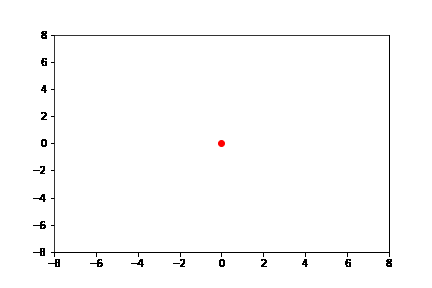

In [27]:
from IPython.display import Image
Image(filename=filename)